In [365]:
import pandas as pd
import os
from datetime import datetime
import sys
import csv
from db import *
from time_series import *
import awarp_wrapper.awarpWrapper as awarp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

#import sys
#sys.path.append('/Volumes/GoogleDrive/Mon Drive/Python-helpers')
#from save_obj import *

In [7]:
#csv.field_size_limit(sys.maxsize) # To avoid max field limit on loading df_ts

131072

In [10]:
df_activity = pd.read_csv("data/merged_tables/view_user_activity.csv", 
                                   encoding='utf-8', 
                                   engine='python')

In [ ]:
len(df_activity.author_id.unique())

In [ ]:
df_activity.shape

In [340]:
# First we filter out the author with low tweet count
# This is mostly authors that are retweeted or quoted 
# by another active user from this dataset.
authors = df_activity.groupby('author_id').size()

In [346]:
authors = set(authors[authors > 1000].index)
len(authors)

19484

In [347]:
df_activity = df_activity[df_activity["author_id"].isin(authors)]

In [579]:
df_activity.shape

(57643290, 3)

In [23]:
# Transform the created_at column into datetime
df_activity["created_at_dt"] = df_activity["created_at"].apply(lambda x: 
                                    datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [580]:
df_activity.head()

,author_id,created_at,created_at_dt
0,21477074,2010-11-04 01:42:54,2010-11-04 01:42:54
1,15120297,2010-11-04 01:42:54,2010-11-04 01:42:54
2,15120297,2010-11-04 01:42:54,2010-11-04 01:42:54
3,15120297,2010-11-04 01:42:54,2010-11-04 01:42:54
4,15120297,2010-11-04 01:42:54,2010-11-04 01:42:54


In [350]:
%%time
df = df_activity.groupby("created_at_dt").count()

CPU times: user 51.2 s, sys: 27.4 s, total: 1min 18s
Wall time: 1min 21s


In [351]:
df.drop(columns=["author_id"], inplace=True)

In [352]:
df.rename(columns={"created_at": "count"}, inplace=True)

In [404]:
df.head()

,count
created_at_dt,
2010-11-04 01:42:54,2036
2010-11-04 01:42:55,3979
2010-11-04 01:42:56,2736
2010-11-04 01:42:57,3216
2010-11-04 01:42:58,2373


In [621]:
df_test = df.copy()
df_test["date"] = df_test.index
df_test = (df_test["date"].dt.floor('d')
            .value_counts()
            .rename_axis('date')
            .reset_index(name='count'))

In [623]:
df_test.head()

,date,count
0,2019-02-20,78345
1,2019-02-19,78099
2,2019-02-22,78079
3,2019-02-21,77993
4,2019-02-13,77568


In [588]:
df_filt = df[(df.index > datetime(2018, 10, 1, 0, 0, 0)) & 
             (df.index < datetime(2019, 4, 1, 0, 0, 0))].copy()

In [589]:
df_filt["dt"] = df_filt.index

In [590]:
df_filt = (df_filt["dt"].dt.floor('d')
                        .value_counts()
                        .rename_axis('date')
                        .reset_index(name='count'))

In [591]:
df_filt.sort_values(by="date", inplace=True)

In [603]:
df_filt["count"].mean()

64843.96703296703

Text(0.5, 0, 'Date')

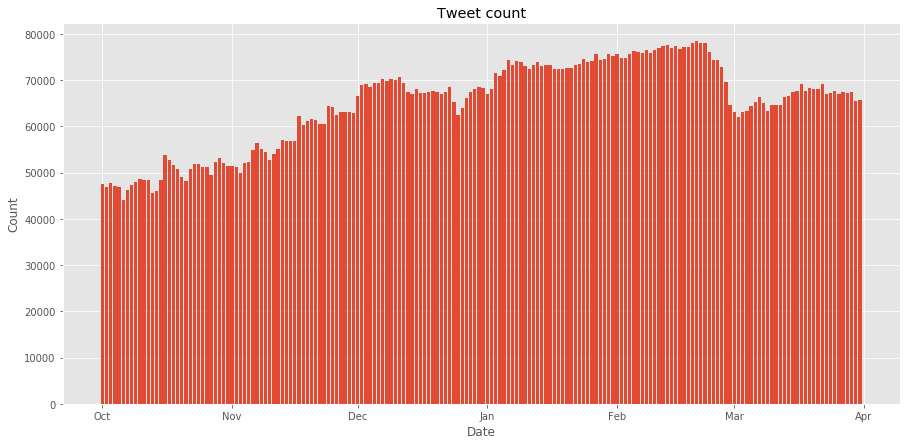

In [409]:
#set ggplot style
plt.style.use('ggplot')

#plot data
fig, ax = plt.subplots(figsize=(15,7))
ax.bar(df_filt["date"], df_filt['count'])

#set ticks every week
ax.xaxis.set_major_locator(mdates.MonthLocator())
#format date
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.set_title('Tweet count')
ax.set_ylabel('Count')
ax.set_xlabel('Date')

In [604]:
T = 24*3600

In [624]:
df.head()

,count
created_at_dt,
2010-11-04 01:42:54,2036
2010-11-04 01:42:55,3979
2010-11-04 01:42:56,2736
2010-11-04 01:42:57,3216
2010-11-04 01:42:58,2373


In [ ]:
tmp = pd.DataFrame({"A": [1, 2, 3, 4, 5], "B": []})

In [625]:
%%time
df_roll = df.rolling(str(T)+'s').sum()

CPU times: user 1.58 s, sys: 865 ms, total: 2.44 s
Wall time: 1.83 s


In [628]:
df_roll.head()

,count
created_at_dt,
2010-11-04 01:42:54,2036.0
2010-11-04 01:42:55,6015.0
2010-11-04 01:42:56,8751.0
2010-11-04 01:42:57,11967.0
2010-11-04 01:42:58,14340.0


In [634]:
df_roll["count"].mean()

87306.89525861619

In [606]:
df_roll_filt = df_roll[(df_roll_filt.index > datetime(2018, 10, 1, 0, 0, 0)) & 
                       (df_roll_filt.index < datetime(2019, 4, 1, 0, 0, 0))].copy()

In [607]:
df_roll_filt.shape

(11801602, 1)

In [617]:
test = df_activity[(df_activity.created_at_dt > datetime(2018, 10, 1, 0, 0, 0)) & 
            (df_activity.created_at_dt < datetime(2019, 4, 1, 0, 0, 0))]

In [618]:
test.shape

(31883330, 3)

In [613]:
df_roll_filt.head()

,date,count
4304,2018-10-01 00:00:00,609
4229,2018-10-01 01:00:00,699
4334,2018-10-01 02:00:00,543
4339,2018-10-01 03:00:00,536
4061,2018-10-01 04:00:00,983


In [608]:
df_roll_filt["dt"] = df_roll_filt.index

In [609]:
df_roll_filt = (df_roll_filt["dt"].dt.floor('h')
                                  .value_counts()
                                  .rename_axis('date')
                                  .reset_index(name='count'))

In [610]:
df_roll_filt.sort_values(by="date", inplace=True)

Text(0.5, 0, 'Date')

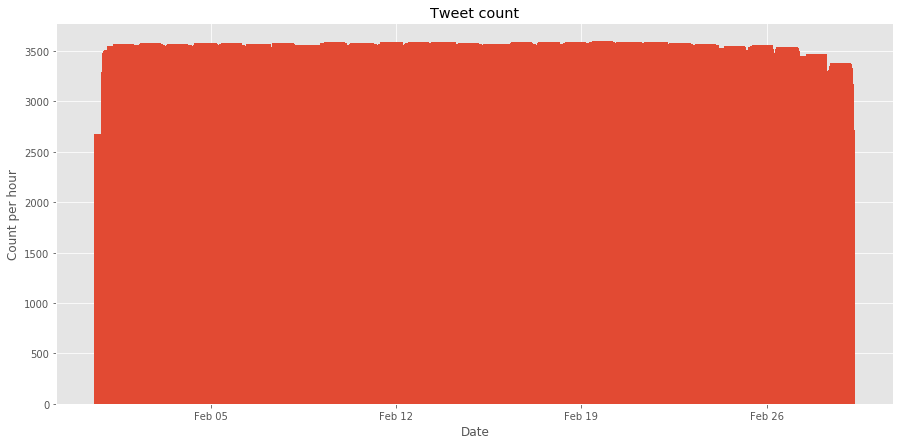

In [644]:
#set ggplot style
plt.style.use('ggplot')

#plot data
data = df_roll_filt[(df_roll_filt["date"] >= datetime(2019, 2, 1, 0, 0, 0)) & 
                    (df_roll_filt["date"] < datetime(2019, 3, 1, 0, 0, 0))]
fig, ax = plt.subplots(figsize=(15,7))
ax.bar(data["date"], data['count'])

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#format date
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

ax.set_title('Tweet count')
ax.set_ylabel('Count per hour')
ax.set_xlabel('Date')

In [559]:
# We observe the ten biggest windows
# 1. Take the datetime corresponding to max window, this is the right bound
# 2. To this value, substract the size of the window to obtain the left bound
# 3. Take out all windows that intersect with more than half of the current window w
#    To do this, we delete all window w' where w' > w-T/2 and w' < w+T/2
# 4. Add the current window to a list
# 5. Back to 1 until we get the desired amount of biggest windows. 
new_df = df_roll.copy()
peaks = []
n = 10

for i in range(n):
    sys.stdout.write('\r'+ str(round(i*100/n))+'%  ')
    dt_max = new_df.idxmax()[0]
    dt_left = dt_max - timedelta(seconds=T)
    new_df = pd.concat([new_df.loc[:dt_max-timedelta(seconds=T//2)], 
                        new_df.loc[dt_max+timedelta(seconds=T//2):]])
    peaks.append(dt_max)

sys.stdout.write('\r100%')           

100% 

In [560]:
df_roll.loc[peaks[0]]

count    226529.0
Name: 2019-02-19 22:36:26, dtype: float64

In [399]:
peaks

[Timestamp('2019-02-19 21:09:28'),
 Timestamp('2019-02-20 22:13:29'),
 Timestamp('2019-02-13 21:57:28'),
 Timestamp('2019-02-19 23:09:28'),
 Timestamp('2019-02-20 20:12:10'),
 Timestamp('2019-02-21 21:14:26'),
 Timestamp('2019-02-16 20:26:53'),
 Timestamp('2019-02-12 22:29:22'),
 Timestamp('2019-02-19 19:09:26'),
 Timestamp('2019-02-18 21:28:13')]

In [561]:
# Get the users in each window : 
authors_list = []
for i in range(n):
    sys.stdout.write('\r'+ str(round(i*100/n))+'%  ')
    # Get all authors in the window
    left = peaks[i]-timedelta(seconds=T)
    right = peaks[i]
    authors_set = df_activity[(df_activity["created_at_dt"] >= left) &
                          (df_activity["created_at_dt"] <= right)]["author_id"].unique()
    authors_list.append(authors_set)
sys.stdout.write('\r100%')

100% 

In [649]:
left = peaks[0]-timedelta(seconds=T)
right = peaks[0]
test = df_activity[(df_activity["created_at_dt"] >= left) &
                    (df_activity["created_at_dt"] <= right)]

In [576]:
len(test[test>=50])

956

In [562]:
len(authors_list[0])

14636

In [ ]:
# For each author in the author_set, compute the time serie
TS = time_series.TimeSeries()
author_to_ts = dict()
for i in range(n):
    authors_set = authors_list[i]
    for author in authors_set:
        if author not in author_to_ts:
            dt_list = df_activity[df_activity["author_id"] == author]["created_at_dt"]
            author_to_ts[author] = TS.get_ts_from_datetime(list(dt_list))
            
# Write the time series on disk
#with open("dtw/window_" + str(n) + ".csv") as f:
        

## Rolling sum on individual authors

The assumption was that when a bunch of bots are activated, we will find a peak of activity in a short time period. Since the rolling count on the overall activity does not show any peak of activity, we can make the assumption that the amount of casual tweet in a window is too high to highlight a peak of bot activity. 

The idea is then to do rolling sum on individual authors, and for each author, take all time period T where at least x tweets were created, and keep only the tweets in those time period. This will remove all isolated tweets for each authors.

Then we do rolling sum on the overall activity, and with luck we will have some time period where there is a peak of activity, i.e. a lot of authors are tweeting a lot and at the same time. 

In [440]:
test = [datetime(2018, 6, 6, 14, 0, 5),
        datetime(2018, 6, 6, 14, 0, 10),
        datetime(2018, 6, 6, 14, 0, 11),
        datetime(2018, 6, 6, 14, 0, 20),
        datetime(2018, 6, 6, 14, 0, 25),
        datetime(2018, 6, 6, 14, 0, 30),
        datetime(2018, 6, 6, 14, 0, 40),
        datetime(2018, 6, 6, 14, 0, 42),
        datetime(2018, 6, 6, 14, 0, 43),
        datetime(2018, 6, 6, 14, 0, 55)]

In [667]:
def frequent_tweet(list_created_at, period, keep_threshold):
    window_size = timedelta(seconds=period)
    df = pd.DataFrame({'created_at':list_created_at})
    counts = df.groupby('created_at').size()
    df_roll = counts.rolling(str(period)+'s').sum()
    big_windows = list(df_roll[df_roll>=keep_threshold].index)
    if len(big_windows) == 0:
        return []
    else:
        mask = ((df["created_at"]>big_windows[0]-window_size) & 
                (df["created_at"]<=big_windows[0]))
        for i in range(1, len(big_windows)):
            tmp = ((df["created_at"]>big_windows[i]-window_size) & 
                  (df["created_at"]<=big_windows[i]))
            mask = mask | tmp
        tweets = list(df[mask]["created_at"])
        return tweets

In [653]:
test = df_activity[df_activity["author_id"] == df_activity.iloc[0]["author_id"]]

In [663]:
%%time
test_res = frequent_tweet(list(test.created_at_dt), 24*3600, 10)

CPU times: user 567 ms, sys: 9.91 ms, total: 577 ms
Wall time: 578 ms


In [660]:
test.shape

(2214, 3)

In [661]:
len(test_res)

822

In [675]:
%%time
#df_test = df_activity.iloc[:1000000]
test = df_activity.groupby('author_id')["created_at_dt"].apply(lambda x: frequent_tweet(list(x), T, 10))

CPU times: user 10h 44min 6s, sys: 2min 8s, total: 10h 46min 15s
Wall time: 10h 48min 10s


In [547]:
test = df_activity[df_activity.author_id==df_activity.iloc[0].author_id].created_at_dt

In [684]:
len(test)

19484

In [685]:
test.head()

author_id
15913     [2018-04-02 14:42:23, 2018-04-02 15:00:36, 201...
65303     [2014-02-09 12:16:45, 2014-02-09 16:34:43, 201...
742143    [2018-11-07 05:17:14, 2018-11-07 19:04:27, 201...
759251    [2016-11-08 08:49:25, 2016-11-09 00:17:24, 201...
807095    [2016-11-08 08:43:02, 2016-11-09 01:05:37, 201...
Name: created_at_dt, dtype: object

In [683]:
test.to_csv("data/activities_24h_min10.csv", index=True, header=True, encoding='utf-8')

In [ ]:
df_activity.groupby('author_id')['created_at_dt'].apply()

In [173]:
df_roll.loc[:dt_left].shape

(32409108, 1)

In [175]:
df_roll.loc[dt_max:].shape

(3857499, 1)

In [177]:
df_roll.loc[dt_left:dt_max].shape

(43060, 1)

In [176]:
df_roll.shape

(36309665, 1)

In [179]:
pd.concat([df_roll.loc[:dt_left], df_roll.loc[dt_max:]]).shape

(36266607, 1)

In [166]:
dt_left

Timestamp('2019-02-19 10:45:53')

In [161]:
type(dt_max[0])

pandas._libs.tslibs.timestamps.Timestamp

In [149]:
df_roll.index[:5]

DatetimeIndex(['2010-11-04 01:42:54', '2010-11-04 01:42:55',
               '2010-11-04 01:42:56', '2010-11-04 01:42:57',
               '2010-11-04 01:42:58'],
              dtype='datetime64[ns]', name='created_at_dt', freq=None)

In [164]:
df_roll.loc[dt_max[0]]

count    266452.0
Name: 2019-02-19 22:45:53, dtype: float64

In [109]:
#df_filt = df_roll[df_roll["count"] > 100000]

CPU times: user 518 ms, sys: 25.7 ms, total: 543 ms
Wall time: 167 ms


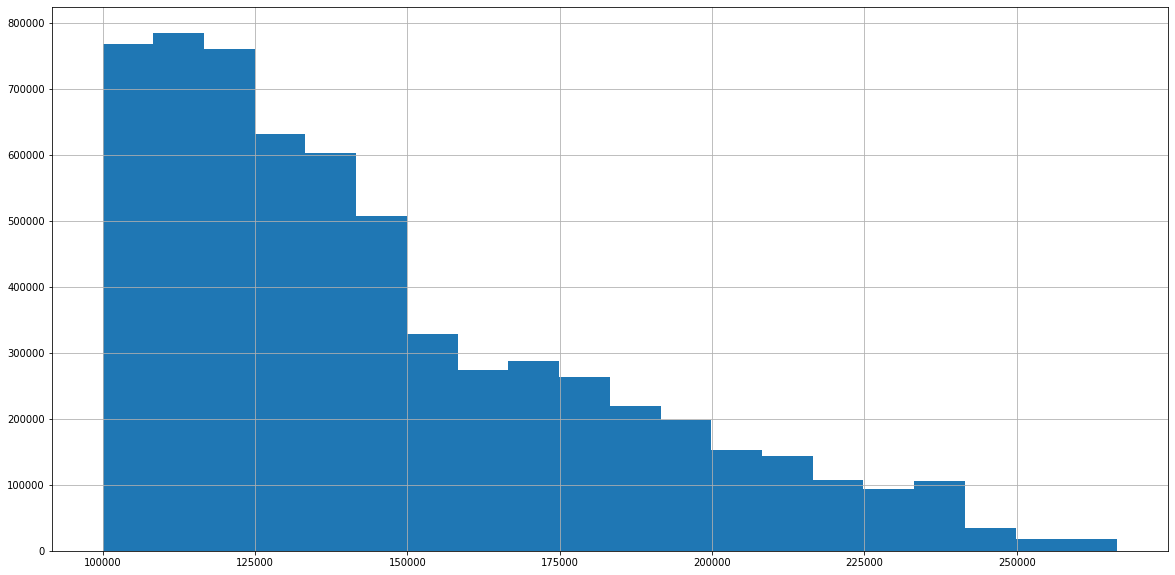

In [131]:
plt.figure(figsize=(20, 10))
df_filt["count"].hist(bins=20)

In [73]:
df_test = pd.DataFrame({'A':[1,1,1,2,2],'B': [0, 1, 2, 4, 4]})

In [32]:
df_test.rolling(3, center=True).sum()

,A,B
0,NaN,NaN
1,3.0,3.0
2,4.0,7.0
3,5.0,10.0
4,NaN,NaN


In [690]:
df_test = pd.DataFrame({'A':[datetime(2018, 6, 6, 14, 0, 5),
                             datetime(2018, 6, 6, 14, 0, 10),
                             datetime(2018, 6, 6, 14, 0, 11),
                             datetime(2018, 6, 6, 14, 0, 20),
                             datetime(2018, 6, 6, 14, 0, 25),
                             datetime(2018, 6, 6, 14, 0, 30),
                             datetime(2018, 6, 6, 14, 0, 40),
                             datetime(2018, 6, 6, 14, 0, 42),
                             datetime(2018, 6, 6, 14, 0, 43),
                             datetime(2018, 6, 6, 14, 0, 55)],
                        'B': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
                        'C': ['a','a','a','a','a','a','a','a','a','a']})

In [691]:
df_test.rolling('7s', on='A').sum()

,A,B
0,2018-06-06 14:00:05,1.0
1,2018-06-06 14:00:10,2.0
2,2018-06-06 14:00:11,3.0
3,2018-06-06 14:00:20,1.0
4,2018-06-06 14:00:25,2.0
5,2018-06-06 14:00:30,2.0
6,2018-06-06 14:00:40,1.0
7,2018-06-06 14:00:42,2.0
8,2018-06-06 14:00:43,3.0
9,2018-06-06 14:00:55,1.0


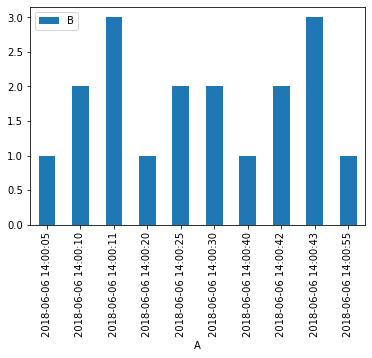

In [70]:
df_test.rolling('7s', on='A').sum().plot.bar(x="A", y="B")

In [237]:
authors = df_activity.author_id.unique()

In [240]:
import random

In [245]:
rand_authors = random.sample(list(authors), 10)

In [254]:
df_test = df_activity[df_activity.author_id.isin(rand_authors)]

In [258]:
TS = TimeSeries(base_time=df_activity.created_at_dt.min(),
                 end_time=df_activity.created_at_dt.max())
df_test2 = (df_test.groupby('author_id')['created_at_dt']
                .apply(lambda x: list(x))
                .reset_index(name='activity'))
df_test2["tweet_count"] = df_test2["activity"].apply(len)
df_test2 = df_test2[df_test2.tweet_count>0]
df_test2["ts"] = df_test2["activity"].apply(lambda x: TS.get_encoded_ts(x))
df_test2 = df_test2.drop(columns=["tweet_count", "activity"])
#df_test.to_csv("data/df_bot_ts.csv", index=False, encoding='utf-8')

In [259]:
def compute_awarp(df_author_ts):
    '''
    Takes a dataframe with 'author_id' and 'ts' as columnn. 
    The ts column is already encoded for awarp. 
    Write the time series on disk and call a python wrapper 
    for cpp that will read the file and compute the distances. 
    The wrapper will then write the result on disk. The function 
    then read the file and returns a dataframe with 'author_id_x', 
    'author_id_y' and 'd' representing the distance between two 
    authors.
    '''
    to_write = ""
    for x in df_author_ts.ts:
        for y in x:
            to_write += str(y) + ","
        to_write = to_write[:-1]
        to_write += "\n"

    with open("awarp_wrapper/ts.csv", "w") as f:
        f.write(to_write)
    
    # call the wrapper
    f = awarp.DTW()
    f.run()
    
    # read the output file
    df_out = pd.read_csv('awarp_wrapper/out.txt', sep=" ", header=None, 
                     names = ["author_id_x","author_id_y","d"])
    
    # update the author columns with the right authors
    current_idx = 0
    author_list = list(df_author_ts.author_id)
    cur_count = df_author_ts.shape[0]-1
    count = int((df_author_ts.shape[0]*(df_author_ts.shape[0]-1))/2)
    author_left = []
    author_right = []
    for i in range(len(author_list)-1):
        author_left += [author_list[i]]*cur_count
        cur_count-=1
    cur_count = df_author_ts.shape[0]-1
    for i in range(len(author_list)-1):
        for j in range(i+1, len(author_list)):
            author_right.append(author_list[j])
            
    df_out["author_id_x"] = author_left
    df_out["author_id_y"] = author_right
    
    return df_out
    

In [262]:
df_out = compute_awarp(df_test2)

In [263]:
df_out

,author_id_x,author_id_y,d
0,80914977,89411566,2.00000
1,80914977,91757214,7.81025
2,80914977,353715706,1.00000
3,80914977,559463499,1.41421
4,80914977,1888499617,1.41421
5,80914977,2385208038,1.41421
6,80914977,2441761627,1.41421
7,80914977,3693909805,4.47214
8,80914977,1055944928004595713,1.00000
9,89411566,91757214,7.54983
